In [ ]:
# TODO: Fix the Overfitting of the Model to the Training Data, Make a Better Model

In [1]:
import glob
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from timeit import default_timer as timer

import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Device Agnostic Code
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# Importing the Training and Test Data
train_path = '/content/drive/MyDrive/brain-tumor-mri/Training/'
test_path = "/content/drive/MyDrive/brain-tumor-mri/Testing/"

### Using glob.glob() to extract Training and Test Files

In [4]:
train_labels = []
train_data = []
print("Using glob.glob()")
train_files = glob.glob(train_path+"*")
for file in train_files:
  for image in glob.glob(file+"/*"):
    train_label = os.path.basename(file)
    train_labels.append(train_label)

    # Convert image to NumPy array
    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, dsize=(512,512))

    # Add 1 channel (C, H, W)
    image = np.expand_dims(image, axis = 0)
    train_data.append(image)

Using glob.glob()


In [5]:
test_labels = []
test_data = []
print("Using glob.glob()")
test_files = glob.glob(test_path+"*")
for file in test_files:
  for image in glob.glob(file+"/*"):
    test_label = os.path.basename(file)
    test_labels.append(test_label)

    # Convert image to NumPy array
    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, dsize=(512,512))

    # Add 1 channel (C, H, W)
    image = np.expand_dims(image, axis = 0)
    test_data.append(image)

Using glob.glob()


In [6]:
train_labels = pd.Series(train_labels).astype('category').cat.codes.values
test_labels = pd.Series(test_labels).astype('category').cat.codes.values

In [7]:
train_data = np.vstack(train_data)
train_data = np.expand_dims(train_data, axis = 1)
test_data = np.vstack(test_data)
test_data = np.expand_dims(test_data, axis = 1)

In [8]:
train_data.shape, test_data.shape

((2870, 1, 512, 512), (394, 1, 512, 512))

## Visualize the initial training data

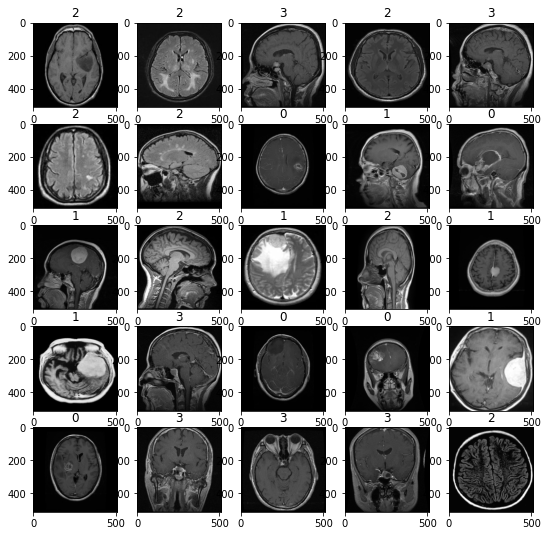

In [9]:
# Plotting training images
torch.manual_seed(42)
fig = plt.figure(figsize = (9,9))
rows, cols = 5,5
for i in range(1, rows*cols+1):
  fig.add_subplot(rows, cols, i)
  random_ids = torch.randint(0, len(train_data),size = [1]).item()
  train_image = train_data[random_ids]
  plt.imshow(train_image.squeeze(), cmap = "gray")
  plt.title(train_labels[random_ids])

### Prepare DataTensor and DataLoader

In [10]:
train_datatensor = torch.utils.data.TensorDataset(torch.from_numpy(train_data).type(torch.float), torch.from_numpy(train_labels).type(torch.LongTensor))
test_datatensor = torch.utils.data.TensorDataset(torch.from_numpy(test_data).type(torch.float), torch.from_numpy(test_labels).type(torch.LongTensor))

<ipython-input-10-d7b7f0e10d69>:1: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  train_datatensor = torch.utils.data.TensorDataset(torch.from_numpy(train_data).type(torch.float), torch.from_numpy(train_labels).type(torch.LongTensor))


In [11]:
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset = train_datatensor,
                              batch_size = BATCH_SIZE,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_datatensor,
                             batch_size = BATCH_SIZE)

In [12]:
# Look at the number of batches
print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f9e40c7b490>, <torch.utils.data.dataloader.DataLoader object at 0x7f9e40c7b850>)
Length of train_dataloader: 90 batches of 32
Length of test_dataloader: 13 batches of 32


In [13]:
# Check out what is inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 512, 512]), torch.Size([32]))

### Creating a Baseline CNN

In [14]:
# Create Model Framework
class BrainTumorModelV0(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size= 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size= 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size= 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size= 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units*128*128,
                  out_features = output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(f"Output shape of conv_block_1: {x.shape}")
    x = self.conv_block_2(x)
    # print(f"Output shape of conv_block_2: {x.shape}")
    x = self.classifier(x)
    # print(f"Output shape of classifier: {x.shape}")
    return x

In [15]:
# Initialize Model
torch.manual_seed(42)
model_0 = BrainTumorModelV0(1,10, 4).to(device)

In [16]:
# Sanity Check the model on random data
toy_model = BrainTumorModelV0(1, 10, 4)
random_data = torch.randn(size = (1, 512, 512))
toy_model(random_data.unsqueeze(0))

tensor([[-0.0387, -0.0217,  0.0155,  0.0303]], grad_fn=<AddmmBackward0>)

### Loss Function and Optimizer

In [17]:
# Loss Function
loss_fn = nn.CrossEntropyLoss().to(device)

# Optimizer
optimizer = torch.optim.Adam(params = model_0.parameters(), lr = 0.001)

### Creating the Training and Test Loop Functions

In [18]:
!pip install torchmetrics
from torchmetrics import Accuracy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
# Accuracy Function
accuracy = Accuracy(task="multiclass", num_classes = 4).to(device)

In [20]:
def train_step(model: nn.Module,
               data_loader : torch.utils.data.DataLoader,
               loss_fn : nn.Module,
               optimizer : torch.optim,
               accuracy,
               device : torch.device = device):

  model.train()
  train_loss, train_acc = 0, 0
  for batch, (X,y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)
    
    # Forward Pass
    y_pred = model(X)

    # Calculate the loss and accuracy
    loss = loss_fn(y_pred, y)
    train_loss += loss
    acc = accuracy(y_pred.argmax(dim = 1), y)
    train_acc += acc

    # Optimizer zero grad
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    # Optimizer
    optimizer.step()

    # Print
    if batch % 15 == 0:
        print(f"Looked at {batch * len(X)}/{len(data_loader.dataset)} samples")

  # Divide total train loss by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train Acc: {train_acc:.2f}")

In [21]:
def test_step(model : nn.Module,
              data_loader : torch.utils.data.DataLoader,
              loss_fn : nn.Module,
              accuracy,
              device : torch.device = device):
  model.eval()
  test_loss, test_acc = 0, 0
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)

      # Forward Step
      y_pred = model(X)

      # Calculate loss and accuracy
      y_loss = loss_fn(y_pred, y)
      test_loss += y_loss
      acc = accuracy(y_pred.argmax(dim = 1), y)
      test_acc += acc
    
    # Take the average loss and accuracy
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

  # Print
  print(f"Test Loss: {test_loss:.5f} | Test acc: {test_acc:.2f}\n")

### Training the Baseline Model

In [22]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Measure start time
start_time = timer()

# Epochs
epochs = 5

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")
  train_step(model = model_0,
             data_loader = train_dataloader,
             loss_fn = loss_fn,
             optimizer = optimizer,
             accuracy = accuracy,
             device = device)
  test_step(model = model_0,
             data_loader = test_dataloader,
             loss_fn = loss_fn,
             accuracy = accuracy,
             device = device)
  
# End time
end_time = timer()
print(f"Training the model took {end_time - start_time} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/2870 samples
Looked at 480/2870 samples
Looked at 960/2870 samples
Looked at 1440/2870 samples
Looked at 1920/2870 samples
Looked at 2400/2870 samples
Train loss: 3.46131 | Train Acc: 0.57
Test Loss: 2.24226 | Test acc: 0.46

Epoch: 1
-------
Looked at 0/2870 samples
Looked at 480/2870 samples
Looked at 960/2870 samples
Looked at 1440/2870 samples
Looked at 1920/2870 samples
Looked at 2400/2870 samples
Train loss: 0.39057 | Train Acc: 0.86
Test Loss: 2.74302 | Test acc: 0.63

Epoch: 2
-------
Looked at 0/2870 samples
Looked at 480/2870 samples
Looked at 960/2870 samples
Looked at 1440/2870 samples
Looked at 1920/2870 samples
Looked at 2400/2870 samples
Train loss: 0.10915 | Train Acc: 0.97
Test Loss: 5.32846 | Test acc: 0.65

Epoch: 3
-------
Looked at 0/2870 samples
Looked at 480/2870 samples
Looked at 960/2870 samples
Looked at 1440/2870 samples
Looked at 1920/2870 samples
Looked at 2400/2870 samples
Train loss: 0.04181 | Train Acc: 0.99
Test Loss: 4.8241